# Synthetic Data Generation + Usage Example

In [1]:
import os
PATH = os.getenv("HOME")
os.chdir(f"{PATH}/watttime-python-client-aer-algo")

In [2]:
!pwd

/Users/jen/watttime-python-client-aer-algo


In [3]:
import numpy as np
import pandas as pd
from watttime import WattTimeHistorical, WattTimeForecast
import evaluation.eval_framework as evu
import math

import seaborn as sns
import matplotlib.pyplot as plt

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

/Users/jen/watttime-python-client-aer-algo/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Step 1: Generate a year of data
- two random dates chosen per week
- max date is now() - 1
- duplicate dates removed

In [4]:
dates_2023 = evu.generate_random_dates(2023)
dates_2024 = evu.generate_random_dates(2024)
distinct_date_list = dates_2023 + dates_2024

## Step 2: Set keyword parameters + generate dataframe
- Assumes at home charging, covers a 5.5 - 8.5 hour variable length window
- To charge this modify mean_length_charge + std_length_charge variables or apply a timedelta() to session_end_time.
- I believe that this data gen process could easily be tweaked to model for home appliances with fixed session lengths

In [5]:
kwargs = {
    "max_percent_capacity": 0.95,  # highest level of charge achieved by battery
    "user_charge_tolerance": 0.8,  # user preferred min charge
    "power_output_efficiency": 0.75,  # power loss. 1 = no power loss.
    "average_battery_starting_capacity": 0.5,  # average starting percent charged
    "start_hour": "09:00:00",  # earliest session can start
    "end_hour": "17:00:00",  # latest session can start
}

## Step 3: Generate dataframe for x # of synthetic users
- synthetic user = user behavior + device characteristics

In [6]:
dfs = evu.execute_synth_data_process(
    distinct_date_list=distinct_date_list, number_of_users=1000, **kwargs
)

100%|██████████| 1000/1000 [00:04<00:00, 209.94it/s]


In [7]:
dfs.shape

(198000, 19)

## Synth Data Distributions

Text(0.5, 1.0, 'length_of_session_in_seconds')

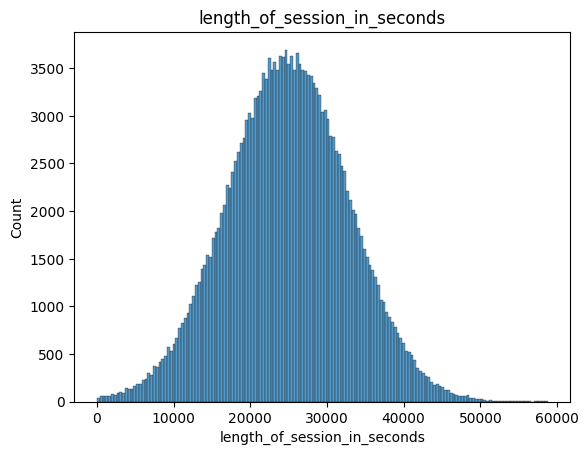

In [8]:
sns.histplot(dfs["length_of_session_in_seconds"]).set_title(
    "length_of_session_in_seconds"
)

Text(0.5, 1.0, 'total_capacity')

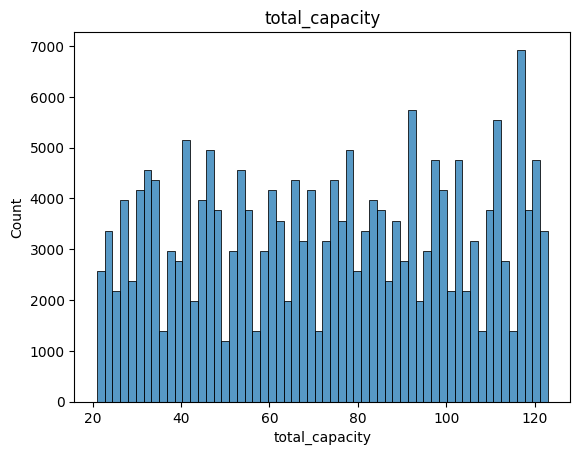

In [9]:
sns.histplot(dfs["total_capacity"]).set_title("total_capacity")

Text(0.5, 1.0, 'power_output_rate')

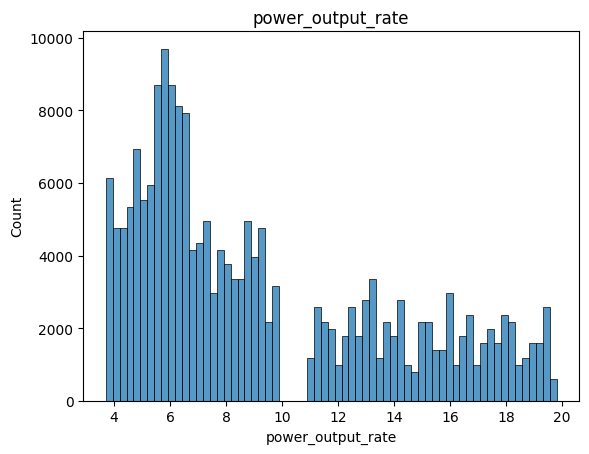

In [10]:
sns.histplot(dfs["power_output_rate"]).set_title("power_output_rate")

## Calculate MOERs

In [ ]:
# taking a subset of data - this takes a while to run
synth_data = dfs.sample(25)
region = "SPP_TX"

synth_data["moer_data"] = synth_data.apply(  # ~1min15sec
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

In [12]:
synth_data["moer_data_actual"] = synth_data.apply(  # ~30 sec
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

In [13]:
get_charging_schedule_lambda = lambda x: x["usage"].values.flatten()
get_total_emissions_lambda = lambda x: x["emissions_co2e_lb"].sum()

In [14]:
synth_data["optimizer_ideal_simple"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data_actual,
        optimization_method="simple",
    ),
    axis=1,
)

synth_data["simple_ideal_charging_schedule"] = synth_data[
    "optimizer_ideal_simple"
].apply(get_charging_schedule_lambda)
synth_data["simple_ideal_emissions"] = synth_data["optimizer_ideal_simple"].apply(
    get_total_emissions_lambda
)

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


<Axes: xlabel='simple_ideal_emissions', ylabel='Count'>

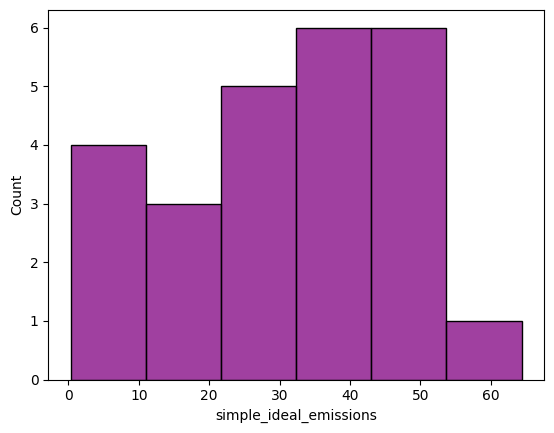

In [15]:
sns.histplot(synth_data["simple_ideal_emissions"], color="purple")

In [16]:
synth_data["optimizer_simple"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["optimizer_simple_schedule"] = synth_data["optimizer_simple"].apply(
    get_charging_schedule_lambda
)
synth_data["optimizer_simple_estimated_emissions"] = synth_data[
    "optimizer_simple"
].apply(get_total_emissions_lambda)
synth_data["optimizer_simple_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_simple.energy_usage_mwh,
    ),
    axis=1,
)

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


<Axes: xlabel='optimizer_simple_estimated_emissions', ylabel='Count'>

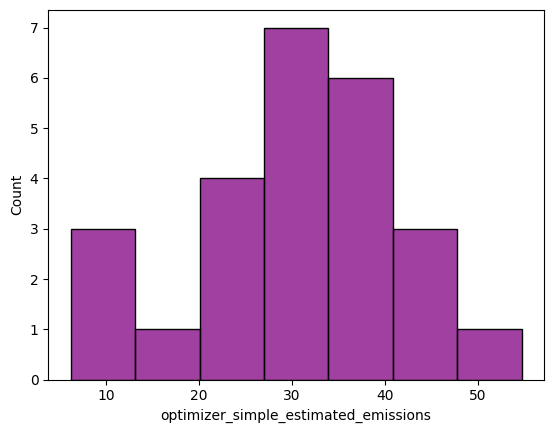

In [17]:
sns.histplot(synth_data["optimizer_simple_estimated_emissions"], color="purple")

<Axes: xlabel='optimizer_simple_actual_emissions', ylabel='Count'>

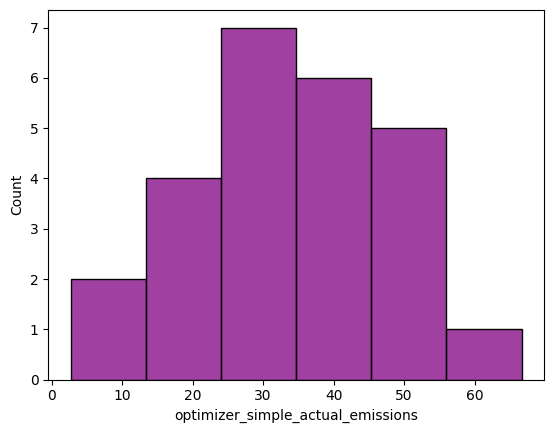

In [18]:
sns.histplot(synth_data["optimizer_simple_actual_emissions"], color="purple")

In [19]:
synth_data["optimizer_baseline"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="baseline",
    ),
    axis=1,
)

synth_data["optimizer_baseline_schedule"] = synth_data["optimizer_baseline"].apply(
    get_charging_schedule_lambda
)
synth_data["optimizer_baseline_estimated_emissions"] = synth_data[
    "optimizer_baseline"
].apply(get_total_emissions_lambda)
synth_data["optimizer_baseline_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_baseline.energy_usage_mwh,
    ),
    axis=1,
)

== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==


<Axes: xlabel='optimizer_baseline_actual_emissions', ylabel='Count'>

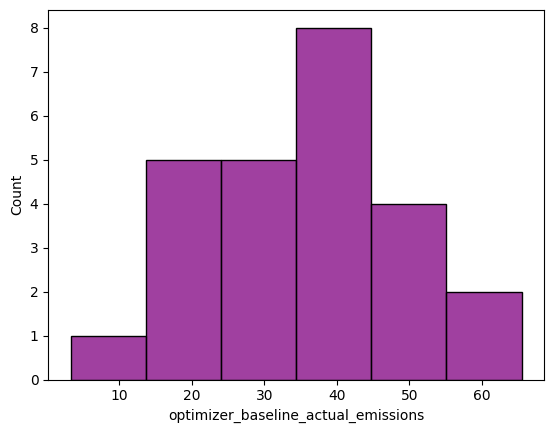

In [20]:
sns.histplot(synth_data["optimizer_baseline_actual_emissions"], color="purple")

## Metrics

In [21]:
synth_data["baseline_difference"] = (
    synth_data["optimizer_simple_actual_emissions"]
    - synth_data["optimizer_baseline_actual_emissions"]
)
synth_data["largest_possible_difference"] = (
    synth_data["simple_ideal_emissions"]
    - synth_data["optimizer_baseline_actual_emissions"]
)

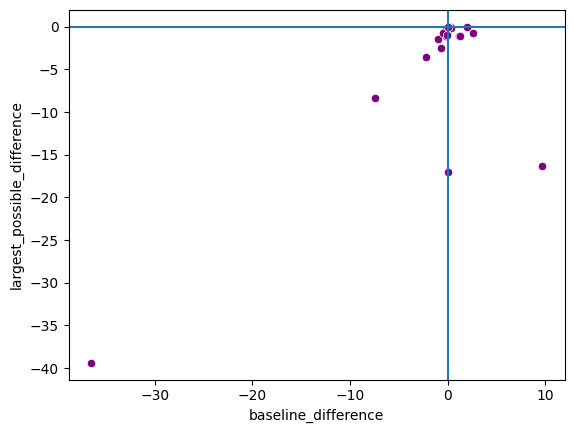

In [22]:
sns.scatterplot(
    synth_data, x="baseline_difference", y="largest_possible_difference", color="purple"
)
plt.axvline(0)
plt.axhline(0)

# cluster at the origin point, sessions where there wasn't opportunity to optimize, even with perfect foresight
# bottom left = sessions where some % of possible optimization ACHIEVED
# bottom right = sessions where some % performed worse than no intervention
# dots along the vline = sessions where optimization possible but missed